<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/7_Linear_multiclass_classification/7_3_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 7: Linear multi-class classification

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

#  7.3  Multi-Class Classification and the Perceptron

In this Section we discuss a natural alternative to OvA multi-class classification detailed in the previous Section.   Instead of training $C$ two class classifiers *first* and *then* fusing them into a single decision boundary (via the *fusion rule*), we can train all $C$ classifiers *simultaneously* to explicitly satisfy the fusion rule directly.  In particular here we derive the *Multi-class Perceptron* cost for achieving this feat, which can be thought of as a direct generalization of the two class perceptron described in [Section 6.4](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_4_Perceptron.html).  

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone datasets
if not Path('chapter_7_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/7_Linear_multiclass_classification/chapter_7_library
else:
    print('chapter_7_library already cloned!')

# clone library subdirectory
if not Path('chapter_7_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/7_Linear_multiclass_classification/chapter_7_datasets
else:
    print('chapter_7_datasets already cloned!')

# clone datasets
if not Path('chapter_7_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/7_Linear_multiclass_classification/chapter_7_images
else:
    print('chapter_7_images already cloned!')
        

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_7_library') 

# import section helper
import section_7_3_helpers

# dataset paths
dataset_path_1 = 'chapter_7_datasets/3class_data.csv'
dataset_path_2 = 'chapter_7_datasets/4class_data.csv'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_7_library already cloned!
chapter_7_datasets already cloned!
chapter_7_images already cloned!


## The Multi-class Perceptron cost function

Once again we deal with an arbitrary multi-class dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$
consisting of $C$ distinct classes of data.  The labels for these classes can be made arbitrarily, but here we will once again employ label values $y_{p}\in\left\{ 0,1,...,C-1\right\} $.  

In the previous Section on OvA multi-class classification we saw how the fusion rule rightfully defined class ownership, partitioning the input space of a dataset given its classes in a fair way.  In particular the fusion rule should *ideally when all weights are properly tuned* predict precisely the labels of our dataset as often as possible as

\begin{equation}
y_p =   \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{p}^T \mathbf{w}_c^{\,}.
\end{equation}

Our aim in this Section is - instead of tuning our each classifier's weights one-by-one and then combining them in this way - to *learn all sets of weights simultaneously so as to satisfy this ideal condition as often as possible*.  Note that for now we will ignore the the beneift of *normalizing* each set of weights $\mathbf{w}_j$, since as discussed in the prior Section this is often ignored in practice.  We will however re-introduce the concept in Section below.

To get started in constructing a proper cost function by which our ideal weights can be determined upon proper minimization, first note that for the *if* the above is to hold for our $p^{th}$ point then we can likewise say that the following is true as well

\begin{equation}
\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,} = \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}.
\end{equation}

Remember geometrically this simply says that the (signed) distance from the point $\mathbf{x}_p$ to its class decision boundary is greater than its distance from every other class's. This is what we want for all of our training datapoints - to have the prediction provided by the fusion rule match our given labels, and hence the above to be true for every point $\mathbf{x}_p$.

By definition - when these weights are are tuned optimally - the right hand side of equation (2) must always be greater than or equal to the left, since the $y_p^{th}$ classifier is considered in the maximum on the right hand side.  This means that their difference - subtracting $\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}$ from both sides - gives a pointwise cost that is *always nonnegative* and minimal at zero

\begin{equation}
g_p\left(\mathbf{w}_0,...,\mathbf{w}_{C-1}\right) = \left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}.
\end{equation}

If our weights are set ideally this value should be zero for as many points as possible - i.e., so that the weights $\mathbf{w}_{y_p}^{\,}$ have been tuned correctly so that indeed the $y_p^{th}$ classifier provides the largest evaluation of $\mathbf{x}_p$. With this in mind, we can then easily form a cost function by taking the *average* of the pointwise cost above as $\frac{1}{P}\sum_{p = 1}^P g_p$ or equivalently 

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \left[ \left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right]
\end{equation}

This *multi-class Perceptron* cost function is nonnegative and - when weights are tuned correctly - is as small as possible.  Thus we can stop *assuming* that we have ideal weights, and minimize this cost in order to find them.  Note here that unlike the OvA - detailed in the previous Section - here we tune all weights *simultaneously* in order to recover weights that satisfy the fusion rule in equation (1) as well as possible.  Like its two class analog (see [Section 6.4](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_4_Perceptron.html)) - the multi-class Perceptron is also *convex* regardless of the dataset employed (also see this Chapter's exercises for further details).  It also has a *trivial solution at zero*, that is when $\mathbf{w}_c = \mathbf{0}$ for all $c$ the cost is minimal which is to be avoided (which is often achievable by initializing any local optimization scheme used to minimize it away from the origin). 

##  Nomenclature and alternative formulations of the multi-class Perceptron

We call this the *multi-class Perceptron cost* not only because we have derived it by studying the problem of multi-class classification 'from above' as we did in [Section 6.4](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_4_Perceptron.html), but also due to the fact that it can be easily shown to be a direct generalization of the two class version introduced in Section 6.4.1.  One easy way to see this is rewrite it - in order to make its appearence more akin to its two class analog - by combining the two terms in each summand using the following simple property of the $\text{max}$ function

\begin{equation}
{\text{max}} \left(s_0,\,s_1,...,s_{C-1}\right) - z = {\text{max}} \left(s_0 - z,\,s_1 - z,...,s_{C-1} - z\right)
\end{equation}

where $s_0,\,s_1,...,s_{C-1}$ and $z$ are scalar values.  Using this we can combine both terms in the $p^{th}$ summand andre-write the multi-class Perceptron in equation (4) cost function as follows

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \underset{ \underset{c \neq y_p }{ c \,=\, 0,...,C-1}  }{\text{max}} \left(0,\mathring{\mathbf{x}}_{p}^T\left( \overset{\,}{\mathbf{w}}_c^{\,} - \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right)\right).
\end{equation}

Here we can see that the corresponding pointwise cost $g_p\left(\mathbf{w}_0,...,\mathbf{w}_{C-1}\right) = \underset{ \underset{c \neq y_p }{ c \,=\, 0,...,C-1}  }{\text{max}} \left(0,\mathring{\mathbf{x}}_{p}^T\left( \overset{\,}{\mathbf{w}}_c^{\,} - \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right)\right)$ now mirrors its the two class analog detailed in 6.4.1 more closely.  In this form it is straightforward to then show that when $C = 2$ the multi-class Perceptron reduces to the two class version.

##  Regularization and the multi-class Perceptron

Note how in minimizing this cost we should - at least formally - subject it to the constraints that all feature-touching portions / normal vectors have unit length.  To express this we will employ our bias / feature-touching weight notation allowing us to decompose each weight vector $\mathbf{w}_c$ into two components

\begin{equation}
\text{(bias):}\,\, b_c = w_{0,c} \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega}_j = 
\begin{bmatrix}
w_{1,c} \\
w_{2,c} \\ 
\vdots \\
w_{N,c}
\end{bmatrix}.
\end{equation}

In this notation each linear combination can be written as $\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,} =  b_{c}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{c}^{\,}$.


The formal desire for the feature-touching weights from all $C$ classifiers to have unit length translates to $\left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2 = 1$ for all $c$. As detailed in the previous Section, formally speaking we need these normal vectors to be unit length if we are to fairly compare the distance of each input $\mathbf{x}_p$ to our two-class decision boundaries.    Doing this, a proper *constrained optimization* problem involving our multi-class Perceptron takes the form

\begin{equation}
\begin{aligned}
\underset{b_{0}^{\,},\,\boldsymbol{\omega}_{0}^{\,},\,...,\,b_{C-1}^{\,},\,\boldsymbol{\omega}_{C-1}^{\,}}{\,\,\,\,\,\,\,\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\,  \frac{1}{P}\sum_{p = 1}^P \left[\left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,b_{c}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{c}^{\,}\right) - \left(b_{y_p}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{y_p}^{\,}\right)\right]\\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2  = 1, \,\,\,\,\,\, c \,=\, 0,...,C-1
\end{aligned}
\end{equation}

This is a proper cost function for *determining* proper weights for our $C$ classifiers: it is always nonnegative, we want to find weights so that its value is small, and it is precisely zero when all training points are classified correctly.  We can solve such problems directly in a variety of ways - e.g., by using projected gradient descent - but it is more commonplace to see this problem approximately solved by *relaxing the constraints* (as we have seen done many times before, e.g., in Sections [6.4.3](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_4_Perceptron.html) and [6.5.3](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_5_SVMs.html)).

This means we can phrase this constrained problem in an unconstrained *regularized* form by relaxing the constraints but penalizing their magnitude. Because we have $C$ constraints we could in theory provide a distinct penalty (or regularization parameter) $\lambda_j$ for each constraint. However for simplicity one can choose a single regularization parameter $\lambda \geq 0$ that is used to penalize the magnitude of all normal vectors simultaneously. This way we need only provide one regularization value instead of $C$ distinct regularization parameters, giving the regularized form of the above problem giving a regularized multi-class Perceptron cost function

\begin{equation}
\frac{1}{P}\sum_{p = 1}^P \left[\left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,b_{c}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{c}^{\,}\right) - \left(b_{y_p}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{y_p}^{\,}\right)\right]+ \lambda \sum_{c = 0}^{C-1} \left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2 
\end{equation}

that must be minimized properly. This regularized form does not quite match the original constrained formulation as regularizing all normal vectors together will not necessarily guarantee that $\left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2 = 1$ for all $c$.  However it will generally force the length of all normal vectors to behave well, e.g., disallowing one normal vector to grow arbitrarily large while one shrinks to almost nothing. As we see many times in machine learning, it is commonplace to make such compromises to get something that is 'close enough' to the original as long as it does work well in practice. This is indeed the case here with $\lambda$ typically set to a small value (e.g., $10^{-3}$ and smaller).

##  Implementing and minimizing a modular multi-class Perceptron in `Python`

To take advantage of the `numpy` libraries fast array operations we use the notation first initroduced in [Section 5.6.3](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html), and repeated in the previous Section, we stack the trained weights from our $C$ classifiers together into a single $\left(N + 1\right) \times C$ array of the form

\begin{equation}
\mathbf{W}=\begin{bmatrix} 
w_{0,0}  &  w_{0,1}  &  w_{0,2}  & \cdots   &  w_{0,C-1}  \\
w_{1,0}  &  w_{1,1}  &  w_{1,2}  & \cdots  &   w_{1,C-1}  \\
w_{2,0}  &  w_{2,1}  &  w_{2,2}  & \cdots  &  w_{2,C-1}  \\
\,\,\, {\vdots}_{\,\,\,}  & {\vdots}_{\,\,\,}  &  {\vdots}_{\,\,\,}  &  \cdots   &    {\vdots}_{\,\,\,}    \\
w_{N,0}  &  w_{N,1} & w_{N,2}  &  \cdots  &  w_{N,C-1}  \\
\end{bmatrix}
\end{equation}

Here the bias and normal vector of the $c^{th}$ classifier have been stacked on top of one another and make up the $c^{th}$ column of the array.  Now lets extend our `model` notation to also denote the evaluation of our $C$ individual linear models as


\begin{equation}
\begin{matrix} 
\text{model}\left(\mathbf{x},\mathbf{W}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{0}^{\,}   &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,}
\end{bmatrix}
\end{equation}

Note: not only is this the *same* linear model used in multi-output regression (as detailed in [Section 5.6](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html)), but the above is a $1\times C$ array of our linear models that can be evaluated at any $\mathbf{W}$.  We can now use precisely the same `model` implementation we have seen in Section 5.6.3, which we repeat below.

In [2]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

With this `model` notation we can more conveniently implement essentially any formula derived from the fusion rule like e.g., the multi-class Perceptron.  For example, we can write the fusion rule itself equivalently as 

\begin{equation}
y = \underset{c \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x},\mathbf{W}\right).
\end{equation}

Likewise we can write the $p^{th}$ summand of the multi-class Perceptron compactly as


\begin{equation}
\left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \mathbf{w}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \mathbf{w}_{y_p}^{\,}. = \left(\underset{c \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x}_p,\mathbf{W}\right)\right) - \text{model}\left(\mathbf{x}_p,\mathbf{W}\right)_{y_p}.
\end{equation}

With this in mind we can then easily implement a multi-class Perceptron in `Python` looping over each point explicitly, as shown below.

In [3]:
# multi-class perceptron regularized by the summed length of all normal vectors
lam = 10**-5  # our regularization paramter 
def multiclass_perceptron(w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)

    # compute counting cost
    cost = 0
    for p in range(len(y)):
        # pluck out current true label
        y_p = y[p] 

        # update cost summand
        cost +=  np.max(all_evals[p,:]) - all_evals[p,int(y_p)]
        
    # return cost with regularizer added
    cost += lam*np.linalg.norm(w[1:,:],'fro')**2
    return cost/float(len(y))

``Python`` code often runs much faster when ``for`` loops - or equivalently ``list comprehensions`` - are written equivalently using matrix-vector ``numpy`` operations (this has been a constant theme in our implementations since linear regression in [Section 5.2](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html)).  This often leads to more compact ``Python`` code as well, since ``for`` loop operations are often more compactly written (even mathematically) as a matrix-vector operations.

Below we show an example of writing the ``multiclass_perceptron`` cost function more compactly than shown previously using ``numpy`` operations instead of the explicit ``for`` loop over the data points.  Both this and the previous implementation compute the same final result for a given set of input weights, but here the computation will be considerably (orders of magnitude) faster.

In [4]:
lam = 10**-5  # our regularization paramter 
def multiclass_perceptron(w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.max(all_evals,axis = 0)    

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))

#### <span style="color:#a50e3e;">Example 1: </span> multi-class perceptron

In this example we minimize the regularized multi-class classifier defined above over a toy dataset with $C=3$ classes used in deriving OvA in the previous Section.

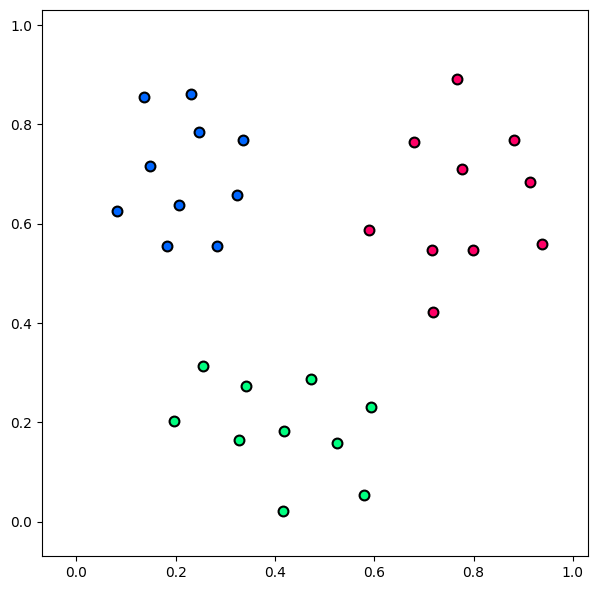

In [5]:
# load in dataset
data = np.loadtxt(dataset_path_1,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# create an instance of the ova demo
demo = section_7_3_helpers.MulticlassVisualizer(data)

# visualize dataset
demo.show_dataset()

# run gradient descent to minimize cost
g = multiclass_perceptron; w = 0.1*np.random.randn(3,3); max_its = 2000; alpha_choice = 10**(-1);
weight_history = demo.gradient_descent(g,w,alpha=alpha_choice,max_its=max_its)

With our multi-class classifier trained by gradient descent we now show how it classifies the entire input space. In the left panel we plot each individual two-class classifier. In the middle panel we show the fused multi-class decision boundary formed by combining these individual classifiers via the fusion rule. In the right panel we plot the cost function value over $200$ iterations of gradient descent.

Note in the left panel that because we did not train each individual classifier in an OvA sense - but trained them together all at once - each individual learned two-class classifier performs quite poorly.  This is fine as our cost function aimed at minimizing all errors of every class simultaneously and not two at a time as with OvA - so we need not expect each individual classifier to cut the space well. However since they were learned together their combination - using the fusion rule - provides a multi-class decision boundary with zero errors.

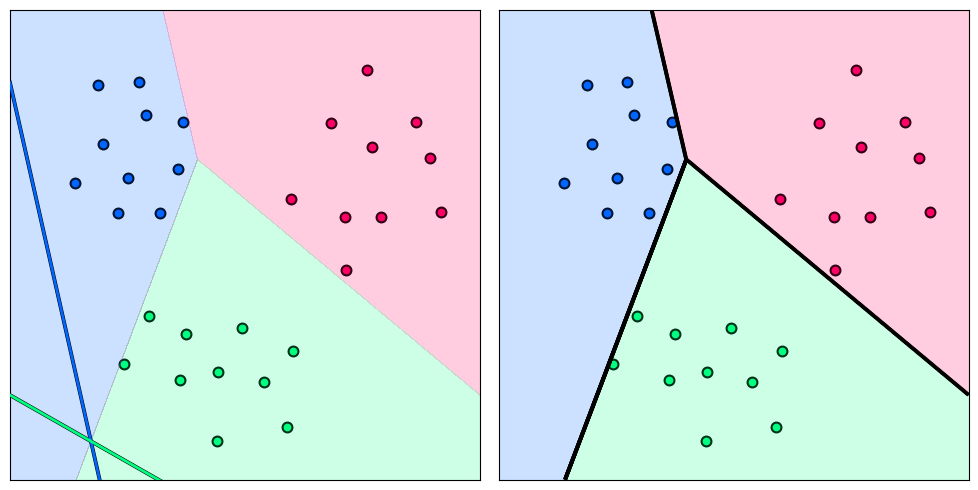

In [6]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(weight_history, cost = multiclass_perceptron)

##  The Multi-class Softmax / Cross Entropy cost function

As we saw previously with the case of the two class perceptron in [Section 6.4](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_4_Perceptron.html), we are often willing to sacrifice a small amount of modeling precision - forming a closely matching smoother cost function to the one we already have - in order to make optimization easier or expand the optimization tools we can bring to bear.  As was the case with the two class perceptron, here too we can *smooth* the multi-class Perceptron cost employing the *softmax* function.  Recall from our discussion of the two class perceptron in Section 6.4.2 that the *softmax function*

\begin{equation}
\text{soft}\left(s_0,s_1,...,s_{C-1}\right) = \text{log}\left(e^{s_0} + e^{s_1} + \cdots + e^{s_{C-1}} \right)
\end{equation}

is a close and smooth approximation to the maximum of $C$ scalar numbers $s_{0},...,s_{C-1}$, i.e.,

\begin{equation}
\text{soft}\left(s_0,s_1,...,s_{C-1}\right) \approx \text{max}\left(s_0,s_1,...,s_{C-1}\right).
\end{equation}

Replacing the $\text{max}$ function in each summand of the multi-class Perceptron *as written in equation (4)* above with its $\text{softmax}$ approximation gives have the following cost function

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right].
\end{equation}

This is referred to as the *multi-class Softmax* cost function is convex but - unlike the Multiclass Perceptron - it has infinitely many smooth derivatives, hence we can use second order methods (in addition to gradient descent) in order to properly minimize it.  Notice that it also no longer has a trivial solution at zero, i.e., when $\mathbf{w}_j = \mathbf{0}$ for all $j$ (just as its two class analog removed this deficiency - see Section 6.4.3).

## Nomenclature and alternative formulations of the multi-class Softmax

This cost function goes by *many* names in practice including: the *multi-class Softmax*, *Multiclass Cross Entropy*, *Softplus*, and *Multiclass Logistic* cost to name a few.  We however will use two fundamental names to refer to it in general.  The first is *Multiclass Softmax*, which we use both because it is a softmax-smoothed version of the Multiclass Perceptron and because it is the natural generalization of the two class version seen in e.g., [Section 6.4.3](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_4_Perceptron.html).  To see this more easily let us smooth the formulation of the Multiclass Perceptron given in equation (6), replacing the $\text{max}$ with the $\text{softmax}$ approximation, giving an equivalent but different formulation than the one above

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P  \text{log}\left(1 + \sum_{\underset{j \neq y_p}{c = 0}}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \left(\overset{\,}{\mathbf{w}}_c^{\,} - \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right)}  \right).
\end{equation}

Visually this appears more similar to the two class Softmax cost, and indeed does reduce to it when $C = 2$ (and $y_p \in \left\{-1,+1\right\}$ are chosen).

We will also refer to this function as the *multi-class Cross Entropy* cost because it is - likewise - a natrual generalization of the two class version seen in [Section 6.2](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_2_Cross_entropy.html).  To see that this indeed the case we can again re-express the Softmax cost in equation (16) in an equivalent but different way.  To do this note that we take its $p^{th}$ summand and rewrite it using the fact that $\text{log}\left(e^{s}\right) = s$ as

\begin{equation}
\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,} = \text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \text{log}\,e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}.
\end{equation}

Now we can use the $\text{log}$ property that 

\begin{equation}
 \text{log}\left(s\right) - \text{log}\left(t\right) = \text{log}\left(\frac{s}{t}\right) 
\end{equation}

to rewrite the above as 

\begin{equation}
\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \text{log}\,e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}} = \text{log}\left( \frac{\sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}}  {e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}    \right).
\end{equation}

Finally because by the $\text{log}$ property that

\begin{equation}
\text{log}\left(s\right) = -\text{log}\left(\frac{1}{s}\right)
\end{equation}

this can be rewritten equivalently as 

\begin{equation}
\text{log}\left( \frac{ \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}}  {e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}    \right) = -\text{log}\left( \frac{e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}  {\sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}} }    \right) 
\end{equation}

So in sum, we can rewrite 

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = -\frac{1}{P}\sum_{p = 1}^P  \text{log}\left( \frac{e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}  {\sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}} }    \right) .
\end{equation}

Visually this appears more similar to the two class Cross Entropy cost [1], and indeed does reduce to it in quite a straightforward manner when $C = 2$ (and $y_p \in \left\{0,1\right\}$ are chosen).

##  Regularization and the multi-class Softmax

As with the multi-class Percpetron, it is common to *regularize* the Multiclass Softmax via its feature touching weights as 

\begin{equation}
\frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{c = 0}^{C-1}  e^{ b_{c}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{c}^{\,} }  \right) - \left(b_{y_p}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{y_p}^{\,}\right)\right] + \lambda \sum_{c = 0}^{C-1} \left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2 
\end{equation}

where $\lambda \geq 0$ is typically set to a small value like e.g., $10^{-3}$.  In addition to this being more formally appropriate - given that our cost funtions originate with the fusion rule established in the previous Section - this can also be interpreted as a way of preventing local optimization methods like Newton's method (which take large steps) from diverging when dealing with perfectly seperable data.

##  Implementing and minimizing a modular multi-class softmax in `Python`

We can implement the multi-class Softmax cost very similar to how the Multiclass Perceptron was implemented above.  That is, using the compact model notation introduced there

\begin{equation}
\begin{matrix} 
\text{model}\left(\mathbf{x},\mathbf{W}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{0}^{\,}   &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,}
\end{bmatrix}
\end{equation}

we can likewise implement the evaluation of all $C$ classifiers simply as follows.

In [7]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

Likewise we can write the $p^{th}$ summand of the multi-class Softmax (as written in equation (16)) compactly as


\begin{equation}
\left(\underset{c \,=\, 0,...,C-1}{\text{softmax}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}. = \left(\underset{c \,=\, 0,...,C-1} {\text{softmax}}\,\text{model}\left(\mathbf{x}_p,\mathbf{W}\right)\right) - \text{model}\left(\mathbf{x}_p,\mathbf{W}\right)_{y_p}.
\end{equation}

With this more compact way of expressing the multi-class softmax - and with the module `model` having already been written above - we can quickly implement a `Python` efficient implementation of the Multi-class Softmax cost.

In [8]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 10**(-5)  # our regularization paramter 
def multiclass_softmax(w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 0)) 
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))

#### <span style="color:#a50e3e;">Example 2: </span> Multi-class Softmax on a toy dataset with $C=3$ classes

In this example we run the multi-class softmax classifier on the same dataset used in the previous example, first using unnormalized gradient descent and then Newton's method.  In the next Python cell we implement a version of the multi-class softmax cost function complete with regularizer. The weights are formatted precisely as in our implementation of the multi-class perceptron, discussed in Example 1.  We then minimize the softmax cost function using gradient descent - for $200$ iterations using a fixed steplength value $\alpha = 10^{-2}$.

Below we plot the final classification over the entire space in the left and middle panels while the cost function plot from our run of gradient descent is plotted in the right panel. In the left panel are shown the final learned two-class classifiers individually, in the middle the multi-class boundary created using these two-class boundaries and the fusion rule. As with the multi-class perceptron, since the multi-class softmax cost focuses on optimizing the parameters of all $C$ two-class classifiers simultaneously to get the best multi-class fit, each one of the two-class decision boundaries need not perfectly distinguish its class from the rest of the data.

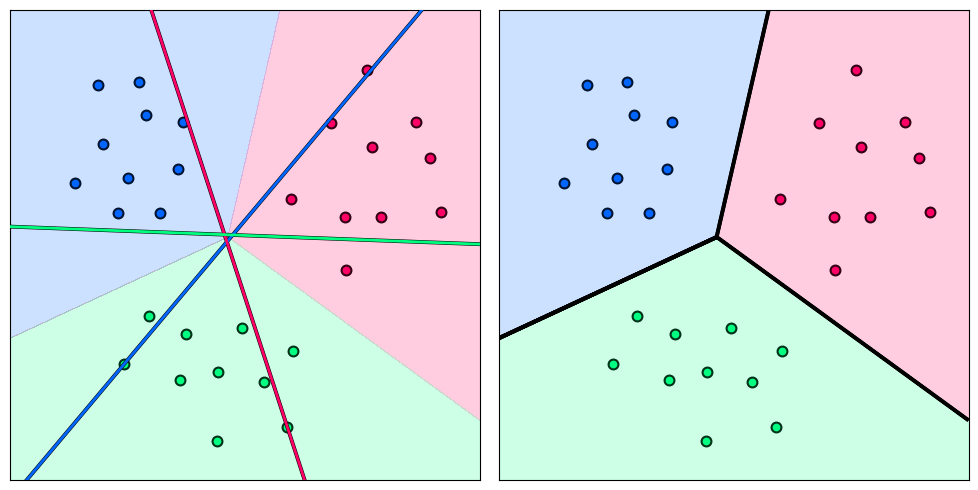

In [9]:
# load in dataset
data = np.loadtxt(dataset_path_1,delimiter = ',')

# create instance of multiclass visualizer
demo = section_7_3_helpers.MulticlassVisualizer(data)

# run gradient descent to minimize cost
g = multiclass_softmax; w = 0.1*np.random.randn(3,3); max_its = 200; alpha_choice = 1;
weight_history = demo.gradient_descent(g,w,alpha=alpha_choice,max_its=max_its)

# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(weight_history, cost = multiclass_softmax)

Optimizing using Newton's method takes just a few steps: in the next cell we re-run the above experiment only using 5 Newton steps.

Below we then print out the same panels as previously, only displaying the results of Newton's method.  Using just a few steps we reach a far lower point on the Multi-class Softmax function - as can be seen by comparing the right panel below with the one shown previously with gradient descent.

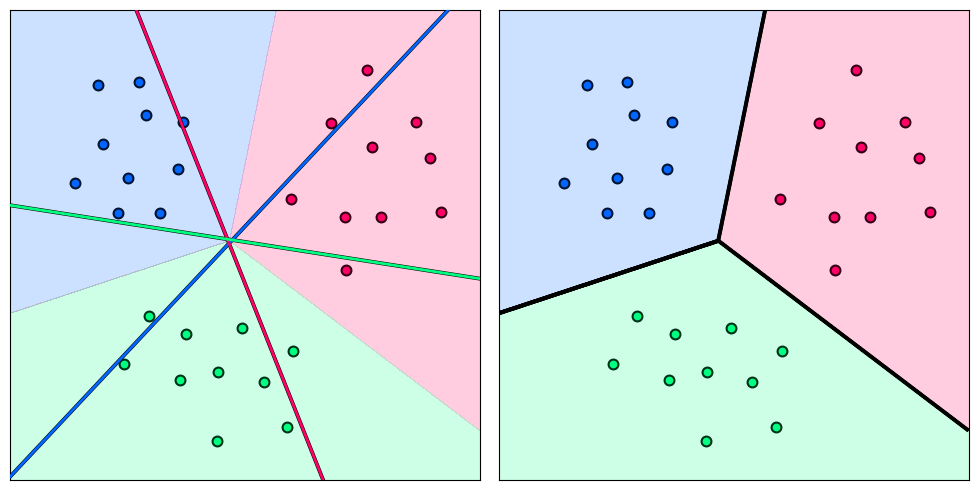

In [10]:
# run newtons method to minimize cost
g = multiclass_softmax; w = 0.1*np.random.randn(3,3); max_its = 5; 
weight_history = demo.newtons_method(g,w,max_its=max_its)

# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(weight_history, cost = multiclass_softmax)


#### <span style="color:#a50e3e;">Example 3: </span> Multi-class Softmax on a toy dataset with $C = 4$ classes

Here we quickly apply Newton's method to fit the Multi-sclass Softmax cost to our toy dataset with $C=4$ classes.  Here points colred red, blue, green, and kahki have label values $y_p = 0$, $1$, $2$, and $3$ respectively.

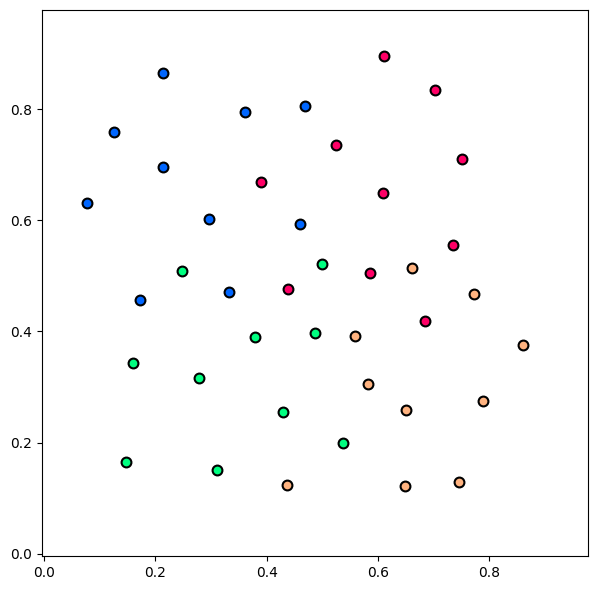

In [11]:
# load in dataset
data = np.loadtxt(dataset_path_2,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# create instance of multiclass visualizer
demo = section_7_3_helpers.MulticlassVisualizer(data)

# visualize dataset
demo.show_dataset()

# run gradient descent to minimize cost
g = multiclass_softmax; w = 0.1*np.random.randn(3,4); max_its = 5; 
weight_history = demo.newtons_method(g,w,max_its=max_its)

Finally, we plot our results, as in the previous Example.

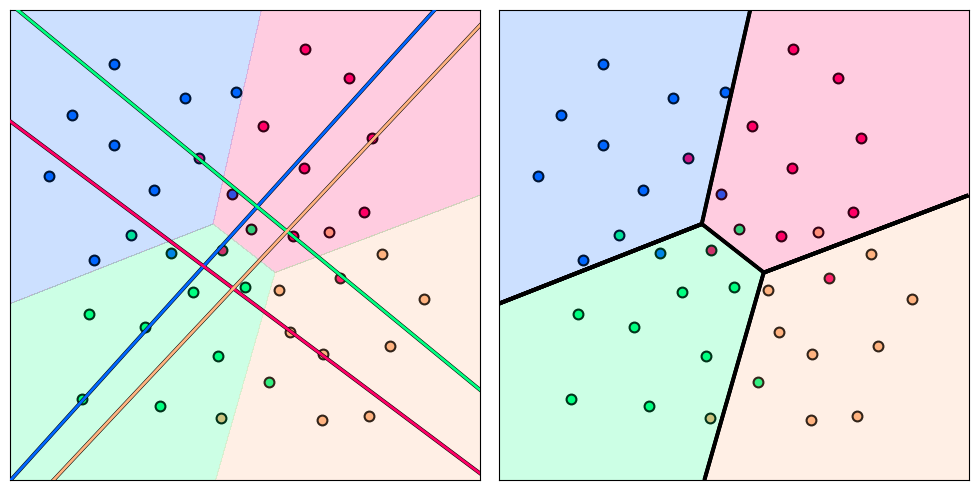

In [12]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(weight_history, cost = multiclass_softmax)

##  End notes

[1]  Care must be taken when implementing any cost function - or mathematical expression in general - involving the exponential function $e^{\left(\cdot\right)}$ in Python. By nature the exponential function grows large very rapidly causing undesired 'overflow' issues even with moderate-sized exponents, e.g., $e^{1000}$. Large numbers like this cannot be stored explicitly on the computer and so are represented symbolically as $\infty$. Additionally, the division of two such large numbers - which is a potentiality when evaluating the summands of the multi-class cost in equation (6) - is computed and stored as a NaN (not a number) causing severe numerical stability issues.

One way we can guard against this issue is by normalizing the data - to fall within a relatively small range - and regularizing the the feature-touching weights, to punish/prevent large weight values. While a workable solution, in practice we can still run into overflow issues immediately after initialization especially when input is high-dimensional. It is therefore good practice to implement one's own version of the exponential function by capping the maximum value it can take, as shown below where $G$ is set to a relatively large value that does not send $e^G$ to $\infty$.  